In [2]:
import os
import math
import shutil
import numpy as np
import pandas as pd
from math import floor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, GRU, TimeDistributed, BatchNormalization
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# CRNN Model

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

## Define dataframes for train and test data

In [4]:
fma_small = pd.read_csv("fma_small.csv")

# Filter the DataFrame based on the string in the "Sets" column
# Training Set
fma_small_train = fma_small[fma_small["Set"] == "training"]
fma_small_train = fma_small_train[0:1500] ###########################################
fma_small_train = fma_small_train.reset_index(inplace=False)
# Create an ID column from DataFrame indices
fma_small_train["True ID"] = fma_small_train.index # Creating True ID since normal ID is song ID.
fma_small_train = fma_small_train[["True ID", "Song ID", "Song Title", "Genre", "Artist ID", "Artist Name", "Set", "Path"]]

# Test set
fma_small_test = fma_small[fma_small["Set"] == "test"]
fma_small_test = fma_small_test.reset_index(inplace=False)
# Create an ID column from DataFrame indices
fma_small_test["True ID"] = fma_small_test.index # Creating True ID since normal ID is song ID.
fma_small_test = fma_small_test[["True ID", "Song ID", "Song Title", "Genre", "Artist ID", "Artist Name", "Set", "Path"]]


## Define Model

In [5]:
import keras.backend as K

def macro_f1_score(y_true, y_pred):
    """
    Calculate macro-average F1 score using Keras backend.

    Parameters:
        y_true (tensor or array): The true class labels (ground truth) as a tensor or Numpy array.
        y_pred (tensor or array): The predicted class labels as a tensor or Numpy array.

    Returns:
        float: The macro-average F1 score.
    """
    # Convert Numpy arrays to Keras backend tensors
    if not tf.is_tensor(y_true):
        y_true = K.constant(y_true)

    if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    
    # Calculate true positives, false positives, and false negatives for each class
    tp = K.sum(y_true * K.round(y_pred), axis=0)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)

    # Calculate precision and recall for each class
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Calculate macro-average F1 score
    macro_f1 = K.mean(f1_score)

    return macro_f1

In [6]:
# Defines function for model artitecture:

def create_model(n_filters, kernel_sizes, pool_sizes, GRU_units, dropout_rate, learning_rate, epochs, batch_size): # 8 Hyperparameters
    # Define the input shape
    input_shape = (235, 352, 3)

    # Define the CRNN architecture
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(filters=n_filters[0], kernel_size=kernel_sizes, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D(pool_size=pool_sizes))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Conv Block 2
    model.add(Conv2D(filters=n_filters[1], kernel_size=kernel_sizes, activation="relu"))
    model.add(MaxPool2D(pool_size=pool_sizes))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Conv Block 3
    model.add(Conv2D(filters=n_filters[2], kernel_size=kernel_sizes, activation="relu"))
    model.add(MaxPool2D(pool_size=pool_sizes))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Recurrent layers
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(GRU_units*2, return_sequences=True))
    model.add(GRU(GRU_units))
    
    # Fully connected layers
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout_rate))
    num_classes = 8
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy", macro_f1_score] # macro_f1_score
                 )
    
    return model

In [9]:
model.metrics_names

['loss', 'accuracy', 'macro_f1_score']

In [8]:
import itertools
from sklearn.model_selection import KFold

tf.random.set_seed(42)
np.random.seed(42)

# Initialize a dictionary to store results for csv format
results_dict = {
    "n_filters": [],
    "kernel_sizes": [],
    "pool_sizes": [],
    "GRU_units": [],
    "dropout_rate": [],
    "learning_rate": [],
    "epochs": [],
    "batch_size": [],
    "avg_accuracy": [],
    "avg_f1": []
}

# Define the parameter grid
#param_grid = {
#    "n_filters": [(16,32,64), (32,64,128), (64,128,256)],
#    "kernel_sizes": [(3,3), (4,4)],
#    "pool_sizes": [(2,2),(3,3)],
#    "GRU_units": [16, 32, 64],
#    "dropout_rate": [0.1, 0.3, 0.5],
#    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
#    "epochs": [32, 64, 128, 256],
#    "batch_size": [32, 64, 128]
#}

# Define the parameter grid
param_grid = {
    "n_filters": [(16,32,64)],
    "kernel_sizes": [(3,3)],
    "pool_sizes": [(2,2)],
    "GRU_units": [8],
    "dropout_rate": [0.1],
    "learning_rate": [0.0001],
    "epochs": [1],
    "batch_size": [64]
}

# Define variables to track the best parameters and performance
best_params = None
best_accuracy = 0.0
best_f1_score = 0.0

# Get all the parameter combinations
param_combinations = list(itertools.product(*param_grid.values()))

# K-fold cross-validation
k = 3
kf = KFold(n_splits=k)
train_datagen = ImageDataGenerator(rescale=1.0/255) # rescale pixel values to [0, 1]


for params in param_combinations:
    # Unpack the parameter values
    n_filters, kernel_sizes, pool_sizes, GRU_units, dropout_rate, learning_rate, epochs, batch_size = params
    accuracy_sum = 0.0
    f1_score_sum = 0.0
    
    # Loops over all the train/validation splits
    for i, (train_index, val_index) in enumerate(kf.split(fma_small_train)):
        print(f"Fold {i}:")

        # Filter training dataframe down to only include data in the current train/validation split generated by KFold.
        fma_small_train_ID = fma_small_train[fma_small_train["True ID"].isin(train_index)]
        fma_small_val_ID = fma_small_train[fma_small_train["True ID"].isin(val_index)]
        
        # Define training and validation generators.
        training_generator = train_datagen.flow_from_dataframe(dataframe = fma_small_train_ID,
                                            directory="SpectrogramData_Formatted/training_Copy",
                                            x_col="Path",
                                            y_col="Genre",
                                            color_mode="rgb",
                                            class_mode="categorical",
                                            target_size=(235, 352),
                                            batch_size=batch_size)

        validation_generator = train_datagen.flow_from_dataframe(dataframe = fma_small_val_ID,
                                            directory="SpectrogramData_Formatted/training_Copy",
                                            x_col="Path",
                                            y_col="Genre",
                                            color_mode="rgb",
                                            class_mode="categorical",
                                            target_size=(235, 352),
                                            batch_size=batch_size)

        # Create the model with the current parameter values
        model = create_model(n_filters, kernel_sizes, pool_sizes, GRU_units, dropout_rate, learning_rate, epochs, batch_size)
        
        # Train and evaluate the model
        model.fit(training_generator, validation_data = validation_generator, epochs=epochs, verbose=2)
        loss, accuracy, f1_score = model.evaluate(validation_generator)
        
        accuracy_sum += accuracy
        f1_score_sum += f1_score
    
    # Calculate the average accuracy across all folds
    avg_accuracy = accuracy_sum / k
    avg_f1_score = f1_score_sum / k
    
    # Check if this combination of parameters gives a better accuracy
    #if avg_accuracy > best_accuracy:
    #    best_accuracy = avg_accuracy
    #    best_params = params
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_params = params
    
    # Store the results in the dictionary
    results_dict["n_filters"].append(n_filters)
    results_dict["kernel_sizes"].append(kernel_sizes)
    results_dict["pool_sizes"].append(pool_sizes)
    results_dict["GRU_units"].append(GRU_units)
    results_dict["dropout_rate"].append(dropout_rate)
    results_dict["learning_rate"].append(learning_rate)
    results_dict["epochs"].append(epochs)
    results_dict["batch_size"].append(batch_size)
    results_dict["avg_accuracy"].append(avg_accuracy)
    results_dict["avg_f1"].append(avg_f1_score)

# Train the best model on the entire training set
print("Retraining best model")
n_filters, kernel_sizes, pool_sizes, GRU_units, dropout_rate, learning_rate, epochs, batch_size = best_params
best_model = create_model(n_filters, kernel_sizes, pool_sizes, GRU_units, dropout_rate, learning_rate, epochs, batch_size)
history = best_model.fit(training_generator, epochs=epochs, batch_size=batch_size, verbose=2)

# Save the final weights and hyperparameter results
best_model.save("best_model_baseline.h5")
results_df = pd.DataFrame(results_dict) # Saves the dictionary to a DataFrame
results_df.to_csv("hyperparameter_results.csv", index=True) # Convert the results DataFrame to a CSV file

print("### DONE ###")

Fold 0:
Found 1000 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
16/16 - 47s - loss: 2.0529 - accuracy: 0.1810 - macro_f1_score: 0.0000e+00 - val_loss: 2.0907 - val_accuracy: 0.0240 - val_macro_f1_score: 0.0000e+00 - 47s/epoch - 3s/step
8/8 [==============================] - 4s 403ms/step - loss: 2.0907 - accuracy: 0.0240 - macro_f1_score: 0.0000e+00
Fold 1:
Found 1000 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
16/16 - 43s - loss: 2.0716 - accuracy: 0.1430 - macro_f1_score: 0.0000e+00 - val_loss: 2.0802 - val_accuracy: 0.0620 - val_macro_f1_score: 0.0000e+00 - 43s/epoch - 3s/step
8/8 [==============================] - 4s 437ms/step - loss: 2.0802 - accuracy: 0.0620 - macro_f1_score: 0.0000e+00
Fold 2:
Found 1000 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
16/16 - 44s - loss: 2.0527 - accuracy

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
hyperparameters = pd.read_csv("hyperparameter_results.csv")
hyperparameters

In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1.0/255)  # rescale pixel values to [0, 1]
test_generator = test_datagen.flow_from_dataframe(dataframe = fma_small_test,
                                        directory="SpectrogramData_Formatted/test_Copy",
                                        x_col="Path",
                                        y_col="Genre",
                                        color_mode="rgb",
                                        class_mode="categorical",
                                        target_size=(235, 352),
                                        batch_size=batch_size)


# Calculate the F1-score for the validation set
#y_true = test_generator.classes
#y_pred = model.predict(test_generator)
#y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision and recall for the validation set
#precision = precision_score(y_true, y_pred_classes, average='weighted')
#recall = recall_score(y_true, y_pred_classes, average='weighted')
#f1 = f1_score(y_true, y_pred_classes, average='weighted')


# Evaluate the best model on the test set
test_loss, test_accuracy, test_f1_score = best_model.evaluate(test_generator)

# Print the best parameters and accuracy
print("Best Parameters:", best_params)
print()
print("Test Accuracy:", test_accuracy)
print("Test f1_score", test_f1_score)
print("Test Loss", test_loss)


## Evaluation Plots

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

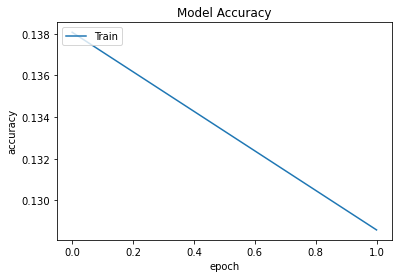

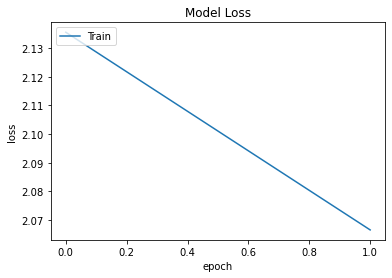

In [27]:
# https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [91]:
print(tf.__version__)

2.9.1
